In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1.3)
%matplotlib inline
%load_ext autoreload
%autoreload 2
np.random.seed(2)

## Load the Data

In [98]:
data = np.loadtxt('data/data.txt').astype(int)
movies = np.genfromtxt('data/movies_utf8.txt', delimiter='\t', dtype=None,encoding=None, 
                       names=['Movie ID','Title','Unknown','Action','Adventure','Animation','Childrens','Comedy','Crime',
                             'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
                              'Thriller','War','Western'], deletechars='')

# Parse movie titles for later plotting
mtitles = np.copy(movies['Title'])
myears = np.copy(movies['Title'])
for j in np.arange(0,1682):
    # Strip quotes and year
    mtitles[j] = mtitles[j].replace('"', '')[:-7]
    # Make the titles more readable
    if mtitles[j][-5:] == ', The':
        mtitles[j] = 'The ' + mtitles[j][:-5]
    if mtitles[j][-3:] == ', A':
        mtitles[j] = 'A ' + mtitles[j][:-3]
    if mtitles[j][-4:] == ', La':
        mtitles[j] = 'La ' + mtitles[j][:-4]
    if mtitles[j][-4:] == ', Il':
        mtitles[j] = 'Il ' + mtitles[j][:-4]
        
    myears[j] = myears[j].replace('"', '')[-5:-1]

myears[266] = -1
myears[1127] = 1995
myears[1200] = 1996
myears[1411] = 1995
myears[1634] = 1986
myears = np.array([int(i) for i in myears])

# Section 4

## All Movies

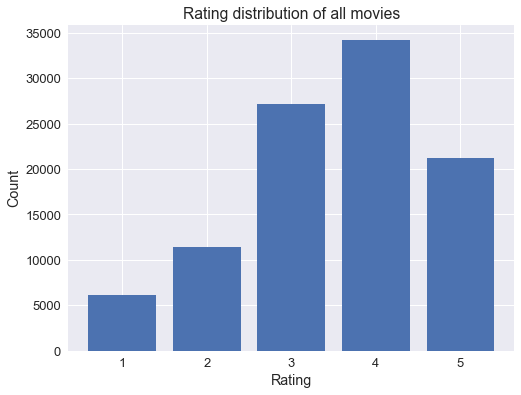

In [3]:
# plot distribution of all ratings
plt.figure(figsize=(8,6))
plt.hist(data[:,2],bins=np.arange(1,7)-0.5,rwidth=0.8);
plt.xticks(np.arange(1,6));
plt.xlabel('Rating');
plt.ylabel('Count');
plt.title('Rating distribution of all movies');

## Popular Movies

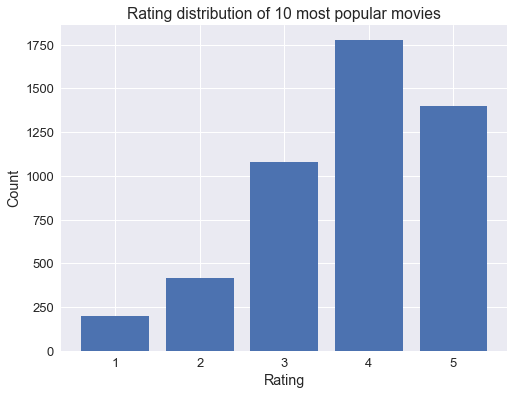

In [4]:
# count number of ratings per movie
r_counts = np.bincount(data[:,1])
# find movie indices with most ratings
pop_inds_mov = np.argpartition(r_counts,-10)[-10:]
# find data indices corresponding to top 10 movies
pop_inds_data = np.nonzero(np.isin(data[:,1], pop_inds_mov))

# thin data to that of top 10 movies
data_pop = data[pop_inds_data,:][0]

# plot distribution of these ratings
plt.figure(figsize=(8,6))
plt.hist(data_pop[:,2],bins=np.arange(1,7)-0.5,rwidth=0.8);
plt.xticks(np.arange(1,6));
plt.xlabel('Rating');
plt.ylabel('Count');
plt.title('Rating distribution of 10 most popular movies');

## Highest Rated Movies

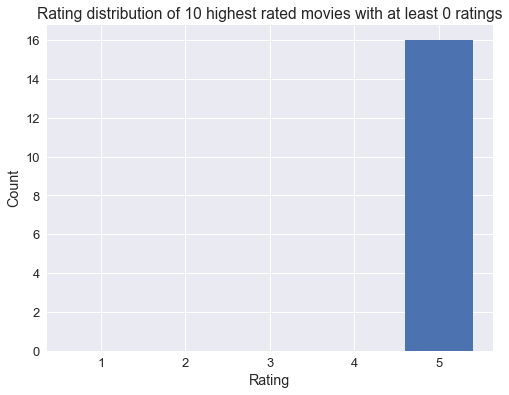

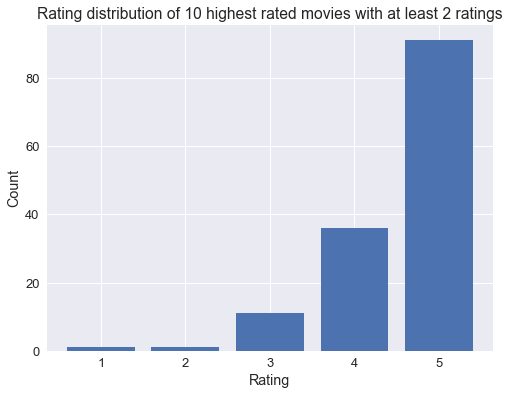

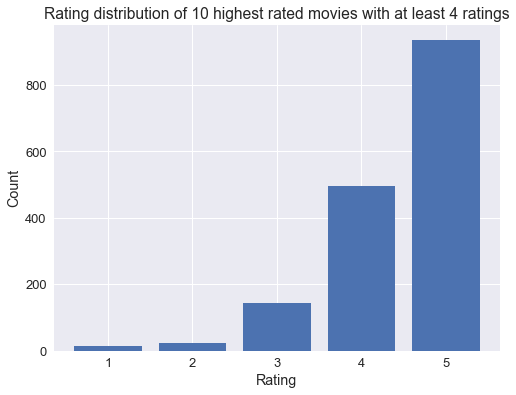

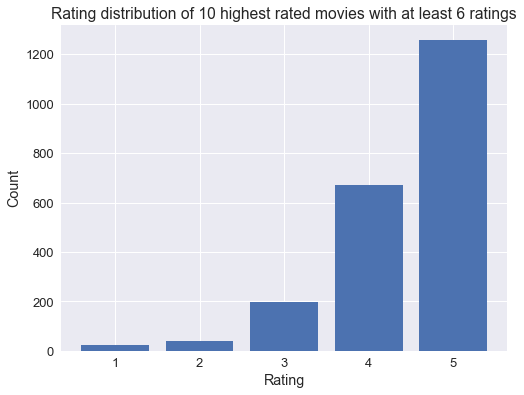

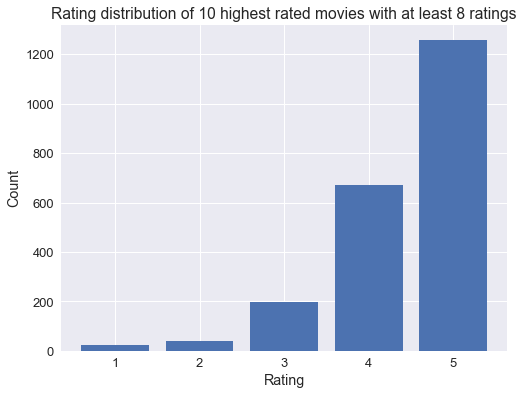

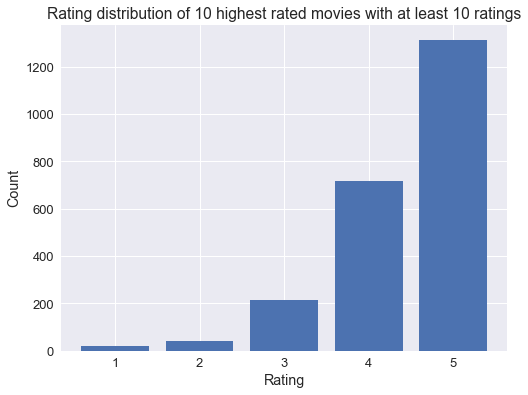

In [5]:
thresh = {0,2,4,6,8,10}
for t in thresh:
    # calculate average rating per movie
    r_aves = np.zeros(1682) 
    for j in np.arange(0,1682):
        r_aves[j] = np.mean(data[np.where(data[:,1]==j+1),2])
        if(len(np.where(data[:,1] == j+1)[0]) < t):
            r_aves[j] = 0
    
    # find movie indices with highest average rating
    ave_inds_mov = np.argpartition(r_aves,-10)[-10:]+1
    # find data indices with corresponding top 10 movies
    ave_inds_data = np.nonzero(np.isin(data[:,1], ave_inds_mov))

    # thin data to that of top 10 movies
    data_ave = data[ave_inds_data,:][0]

    # plot distribution of these ratings
    plt.figure(figsize=(8,6))
    plt.hist(data_ave[:,2],bins=np.arange(1,7)-0.5,rwidth=0.8);
    plt.xticks(np.arange(1,6));
    plt.xlabel('Rating');
    plt.ylabel('Count');
    plt.title('Rating distribution of 10 highest rated movies with at least ' + str(t) + ' ratings');

## Movies by Genre

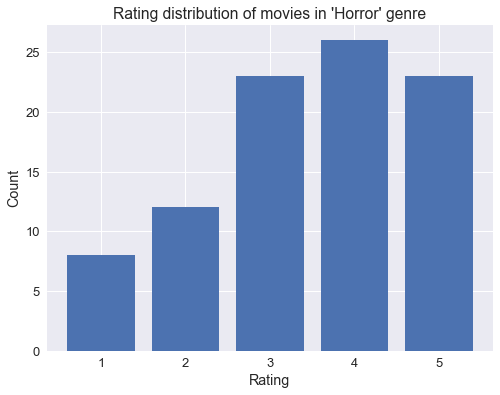

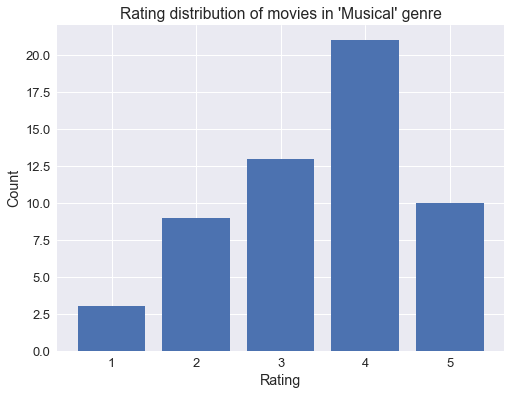

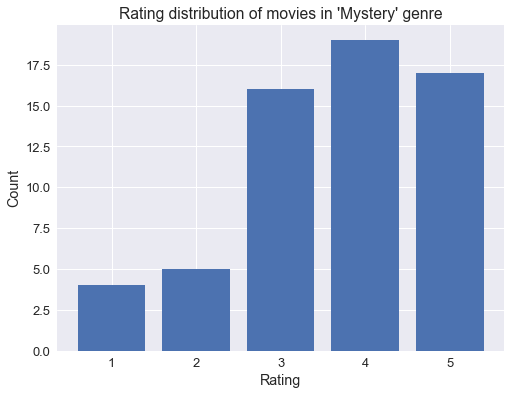

In [6]:
# Genres to compare
genres = ['Horror','Musical','Mystery']

for idx,val in enumerate(genres):
    g_inds_mov = np.array(np.where(movies[val]==1))[0]
    
    plt.subplots(figsize=(8,6))
    plt.hist(data[g_inds_mov,2],bins=np.arange(1,7)-0.5,rwidth=0.8)
    plt.xticks(np.arange(1,6));
    plt.xlabel('Rating');
    plt.ylabel('Count');
    plt.title('Rating distribution of movies in \'%s\' genre'%val);

# Section 5

## Matrix Factorization

In [15]:
# choice of optimizer: 'plain', 'bias' or 'oos'
optimization = 'bias'

Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = movies.shape[0] # movies
    
if optimization == 'plain':
    from collab_0 import train_model, get_err

    print('Factorizing with plain model.')

    reg = 0.1
    eta = 0.03 # learning rate
    K = 20

    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    U, V, err = train_model(M, N, K, eta, reg, Y_train)
    V = V.T # todo: change in py file
    print('Factorization complete.')

elif optimization == 'bias':
    from collab_bias import train_model, get_err

    print('Factorizing with bias model.')

    reg = 0.1
    eta = 0.03 # learning rate
    K = 20

    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    U, V, a, b, mu, err = train_model(M, N, K, eta, reg, Y_train, gbias=True)
    V = V.T # todo: change in py file
    print('Factorization complete.')
    
elif optimization == 'oos':
    # oos model using http://surprise.readthedocs.io/en/stable/matrix_factorization.html
    from surprise.prediction_algorithms.matrix_factorization import NMF
    from surprise import Dataset
    from surprise import Reader
    from surprise import accuracy
    
    reader = Reader(line_format='user item rating', sep='\t')
    model = NMF(n_factors=20)
    surprise_train = Dataset.load_from_file('data/data.txt', reader=reader)
    #surprise_test = Dataset.load_from_file('data/test.txt', reader=reader)
    model.fit(surprise_train.build_full_trainset())
    #predictions = model.test(surprise_test.build_full_trainset().build_testset())
    #err_test = accuracy.rmse(predictions)**2
    V = model.qi
    #print('Test error: %f' % err_test)
    
else:
    print('Invalid optimization method specified')
    

Factorizing with bias model.
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.1
Epoch number 0
Reg error: 0.426186
Epoch number 1
Reg error: 0.403302
Epoch number 2
Reg error: 0.400018
Epoch number 3
Reg error: 0.376293
Epoch number 4
Reg error: 0.361572
Epoch number 5
Reg error: 0.349428
Epoch number 6
Reg error: 0.343521
Epoch number 7
Reg error: 0.332457
Epoch number 8
Reg error: 0.317251
Epoch number 9
Reg error: 0.308279
Epoch number 10
Reg error: 0.302118
Epoch number 11
Reg error: 0.298240
Epoch number 12
Reg error: 0.296715
Epoch number 13
Reg error: 0.315950
Epoch number 14
Reg error: 0.288348
Epoch number 15
Reg error: 0.281858
Epoch number 16
Reg error: 0.276335
Epoch number 17
Reg error: 0.273571
Epoch number 18
Reg error: 0.270959
Epoch number 19
Reg error: 0.269956
Epoch number 20
Reg error: 0.268380
Epoch number 21
Reg error: 0.268920
Factorization complete.


## SVD and Projection

In [35]:
# number of movies to visualize
nmovies = 30

# opacity of axis in plots
axis_opacity = 0.3;

# Perform the SVD

# Following convention in the guide where V is KxN
V_centered = V-np.tile(np.resize(np.mean(V,axis=1),(K,1)),(1,V.shape[1]))
#V_centered = (V-np.tile(np.mean(V,axis=1),(V.shape[1],1)).T).T
A,Si,B = np.linalg.svd(V_centered, full_matrices=False)
VT = np.dot(A[:,0:2].T,V_centered)

# Normalize data for the plots
VT[0] = (VT[0] - np.mean(VT[0]))/np.std(VT[0])
VT[1] = (VT[1] - np.mean(VT[1]))/np.std(VT[1])

# Find the data range for the plots
ylim = [-3,3]
xlim = [-3,3]
yrange = ylim[1]-ylim[0]
xrange = xlim[1]-xlim[0]

### Ten selected movies

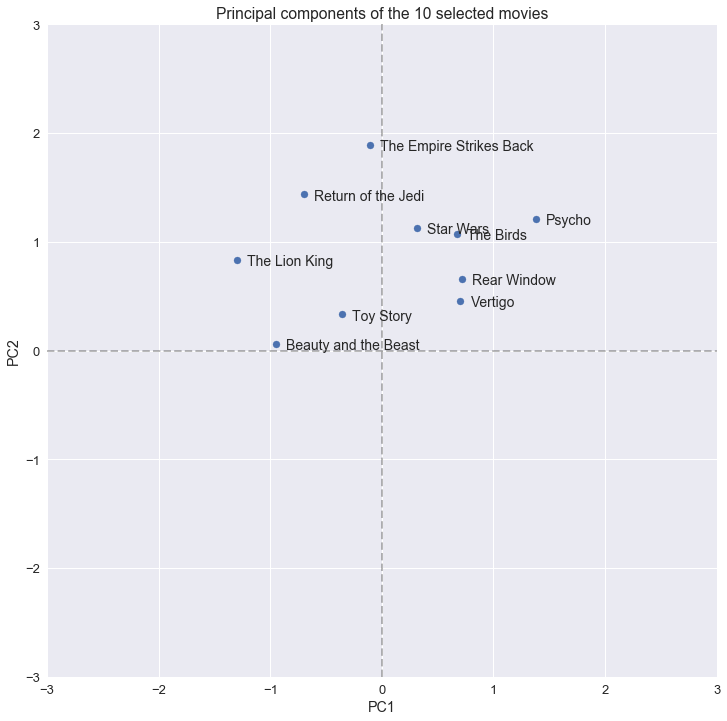

In [17]:
movie_names = ['Star Wars', 'The Empire Strikes Back', 'Return of the Jedi',
                'Rear Window', 'Vertigo', 'Psycho', 'The Birds',
                'Beauty and the Beast', 'The Lion King', 'Toy Story']
inds = np.nonzero(np.isin(mtitles, movie_names))[0]

fig,ax = plt.subplots(figsize=(12,12))
ax.scatter(VT[0,inds],VT[1,inds])
plt.title('Principal components of the %i selected movies' % (nmovies));
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.ylim(ylim)
plt.xlim(xlim)
plt.plot([xlim[0], xlim[1]], [0, 0], 'k--', lw=2, alpha=axis_opacity)
plt.plot([0, 0], [ylim[0], ylim[1]], 'k--', lw=2, alpha=axis_opacity)

## Label movies
for j in inds:
    ax.annotate(mtitles[j],(VT[0,j]+0.015*xrange,VT[1,j]-0.008*yrange),fontsize=14)

### Popular movies

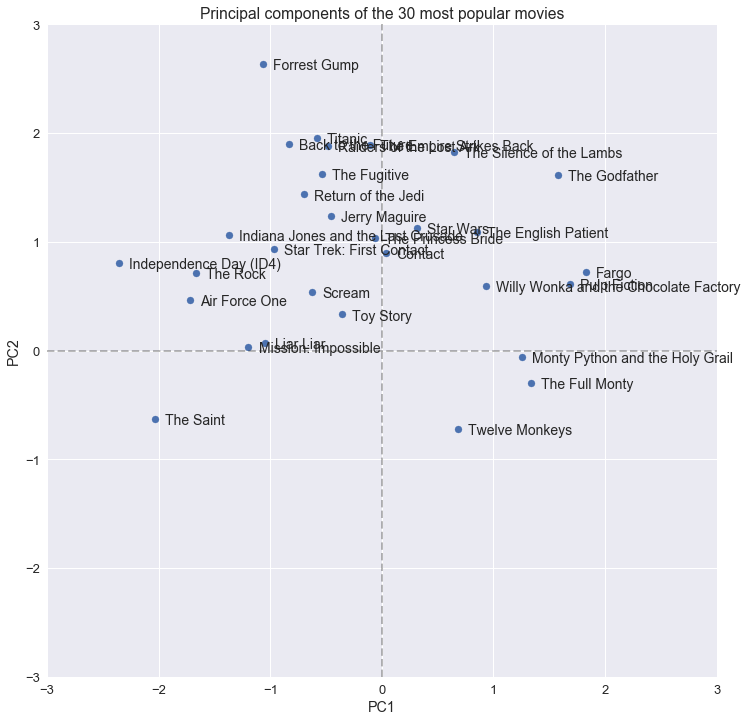

In [36]:
r_counts = np.bincount(data[:,1])[1:]
pop_inds_mov = np.argpartition(r_counts,-nmovies)[-nmovies:]
inds = pop_inds_mov[:nmovies]

fig,ax = plt.subplots(figsize=(12,12))
ax.scatter(VT[0,inds],VT[1,inds])
plt.title('Principal components of the %i most popular movies' % (nmovies));
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.ylim(ylim)
plt.xlim(xlim)
plt.plot([xlim[0], xlim[1]], [0, 0], 'k--', lw=2, alpha=axis_opacity)
plt.plot([0, 0], [ylim[0], ylim[1]], 'k--', lw=2, alpha=axis_opacity)

## Label movies
for j in inds:
    ax.annotate(mtitles[j],(VT[0,j]+0.015*xrange,VT[1,j]-0.008*yrange),fontsize=14)

### Best movies

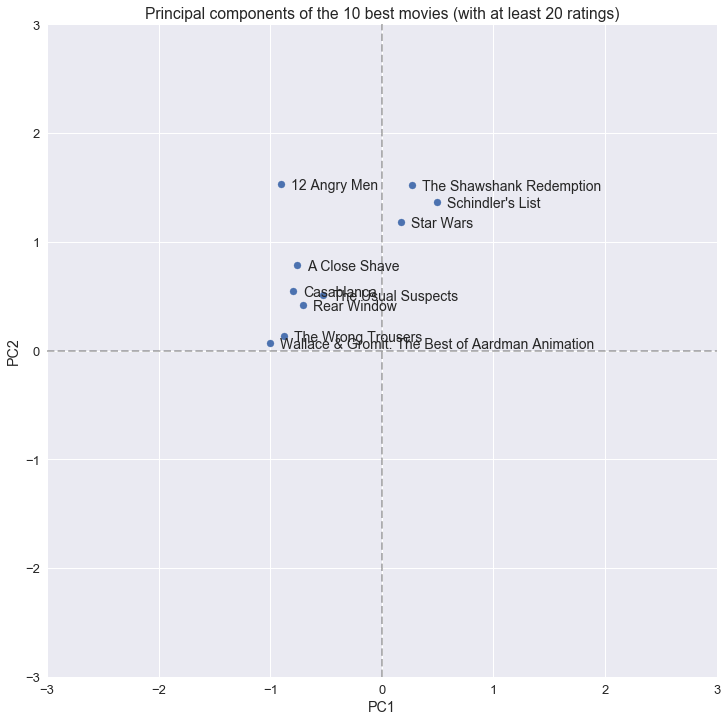

In [11]:
threshold = 20
r_aves = np.zeros(1682) 
for j in np.arange(0,1682):
    r_aves[j] = np.mean(data[np.where(data[:,1]==j+1),2])
    if(len(np.where(data[:,1] == j+1)[0]) < threshold):
        r_aves[j] = 0
best_inds_mov = np.argpartition(r_aves, -nmovies)[-nmovies:]
inds = best_inds_mov

fig,ax = plt.subplots(figsize=(12,12))
ax.scatter(VT[0,inds],VT[1,inds])
plt.title('Principal components of the %i best movies (with at least %i ratings)' % (nmovies, threshold));
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.ylim(ylim)
plt.xlim(xlim)
plt.plot([xlim[0], xlim[1]], [0, 0], 'k--', lw=2, alpha=axis_opacity)
plt.plot([0, 0], [ylim[0], ylim[1]], 'k--', lw=2, alpha=axis_opacity)

## Label movies
for j in inds:
    ax.annotate(mtitles[j],(VT[0,j]+0.015*xrange,VT[1,j]-0.008*yrange),fontsize=14)


### Movies by genre

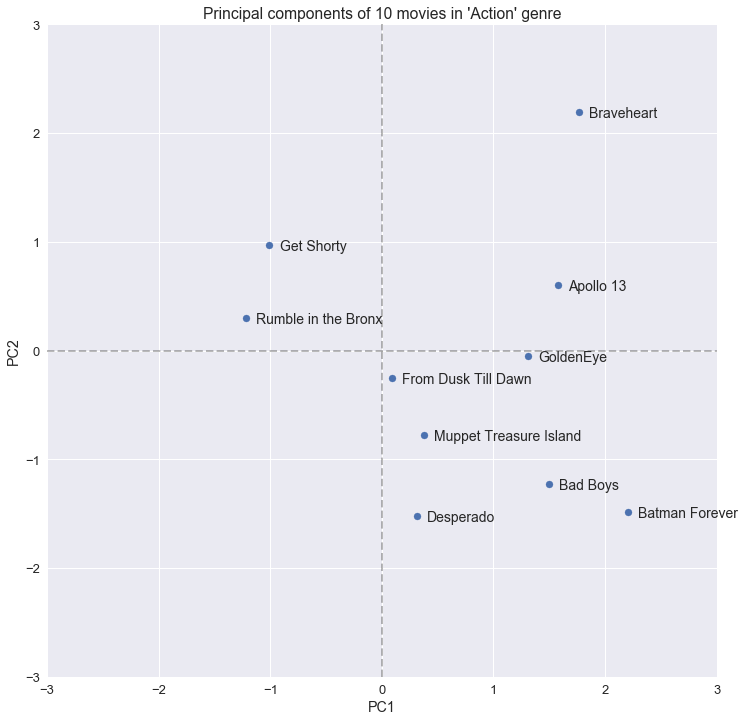

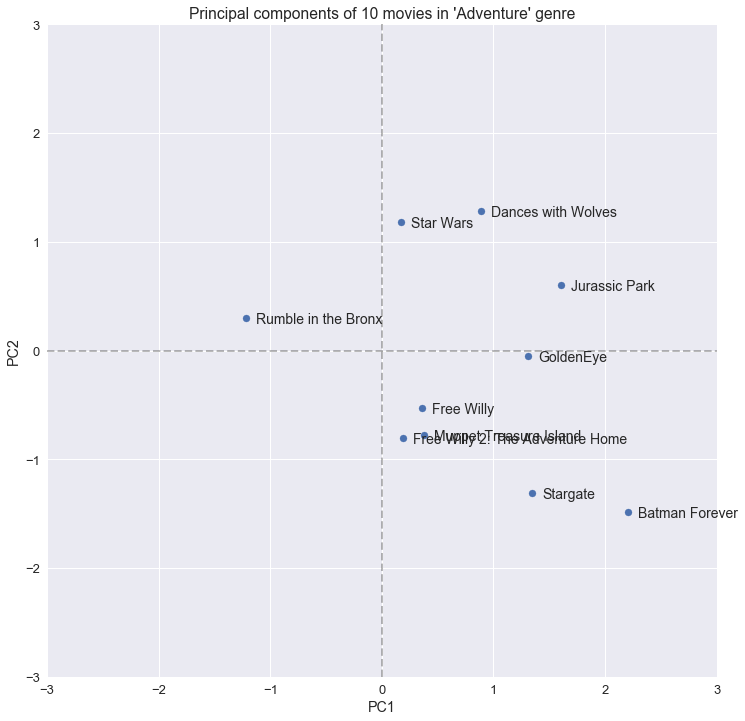

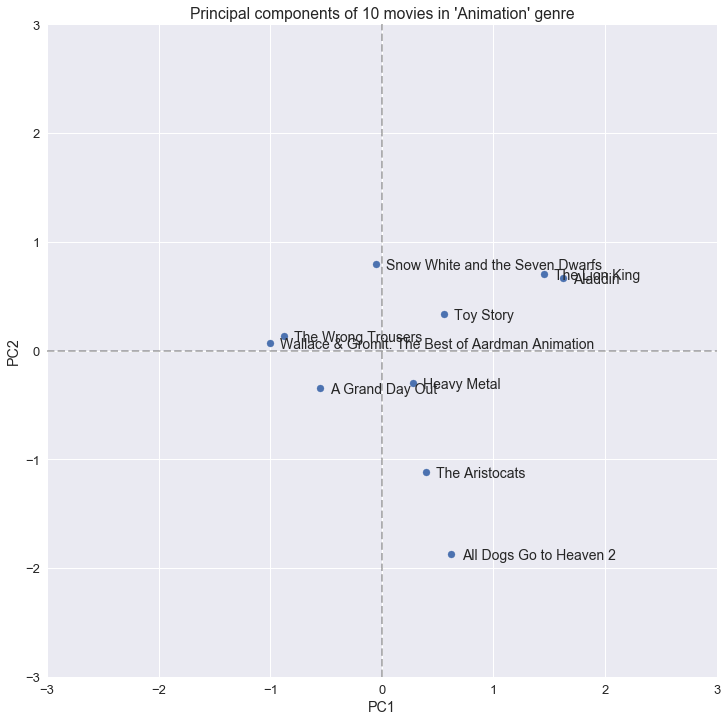

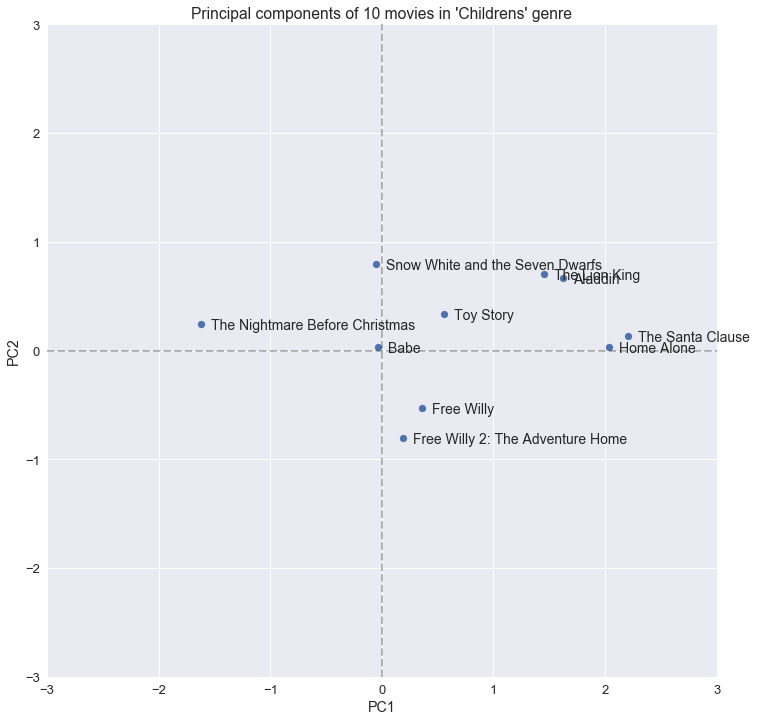

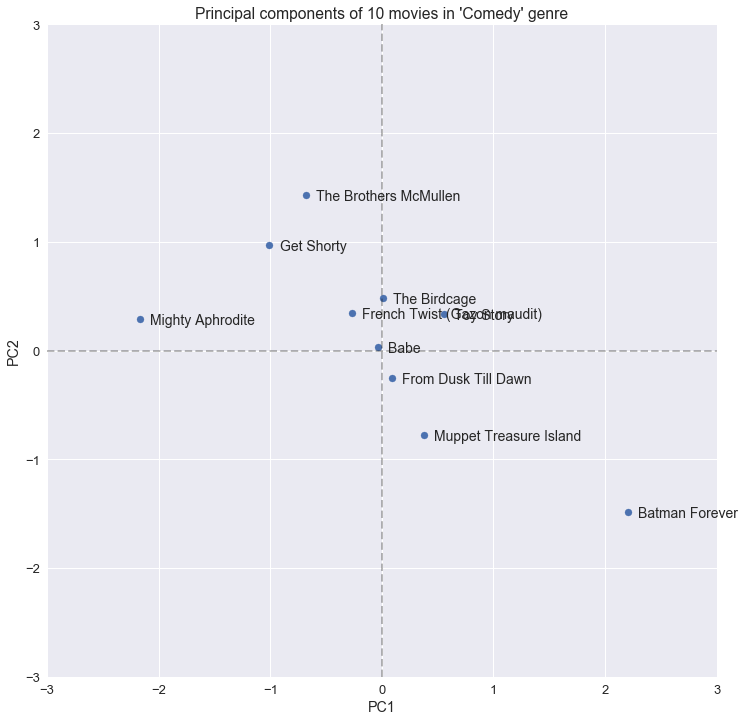

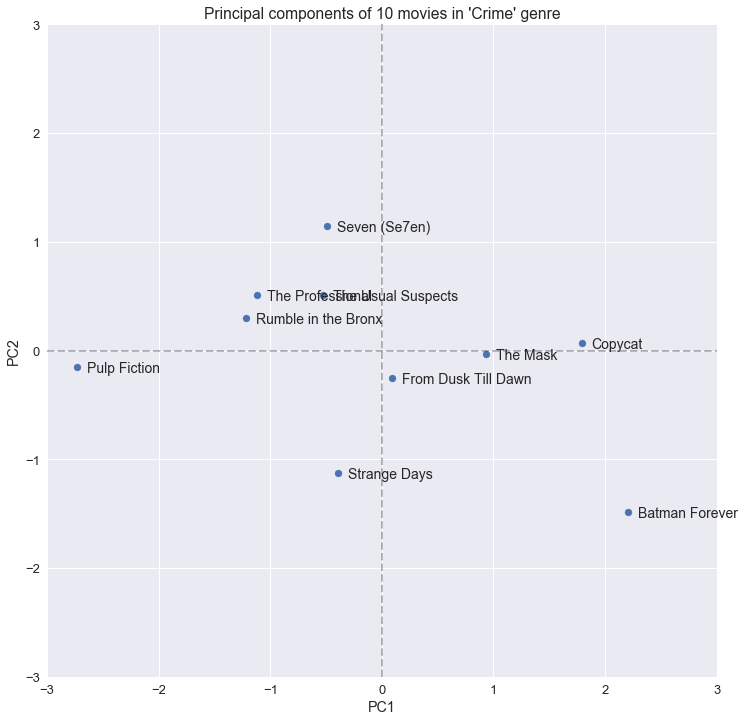

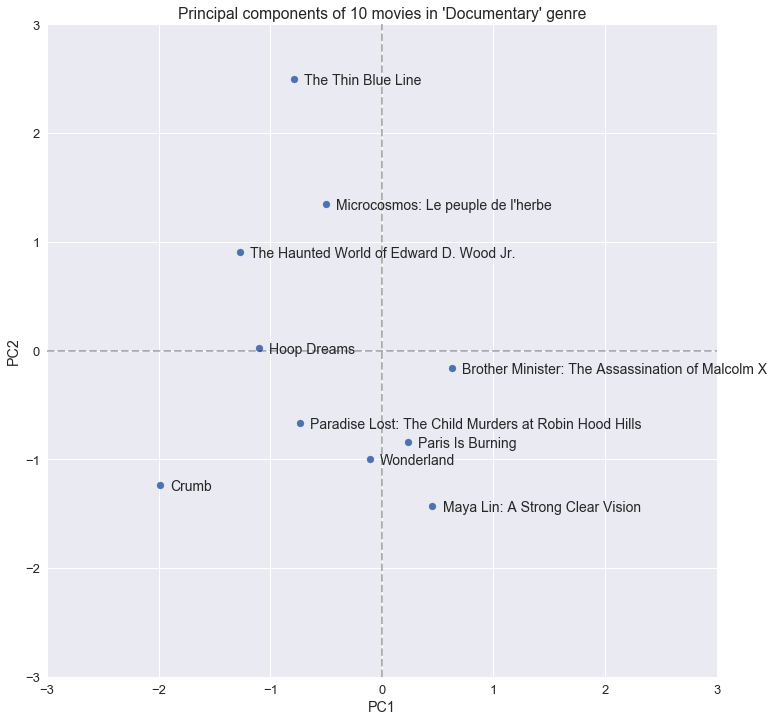

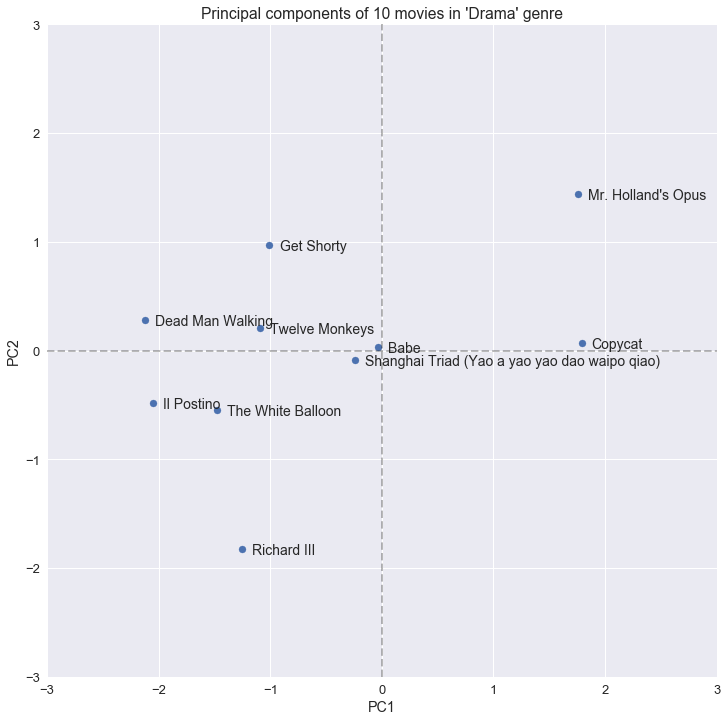

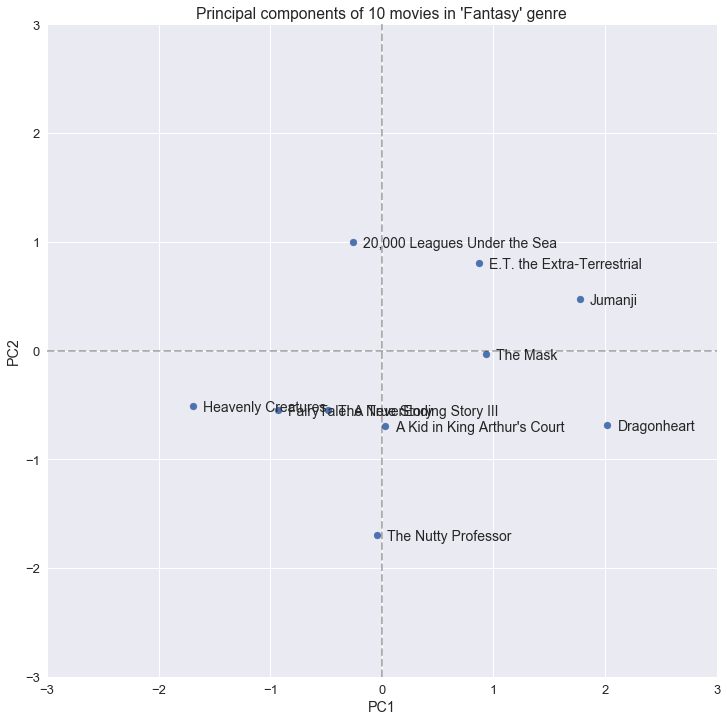

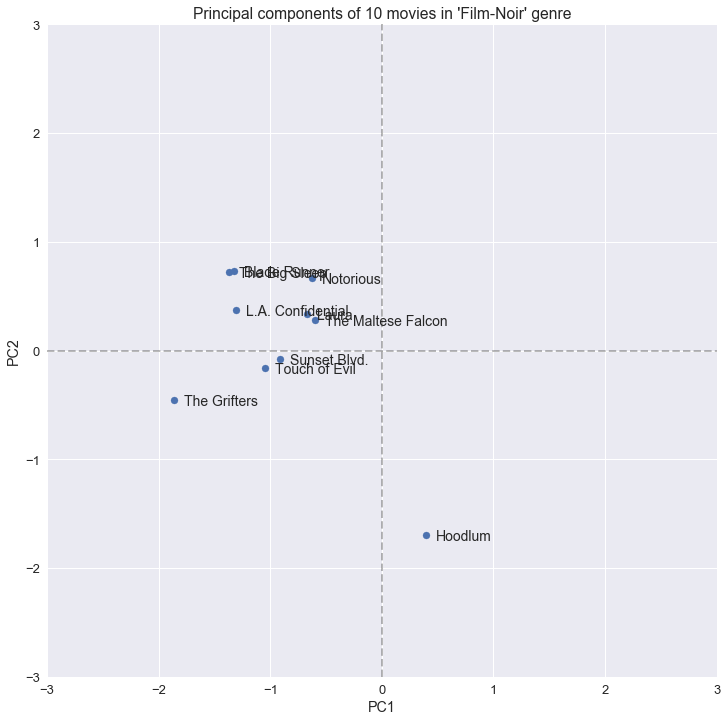

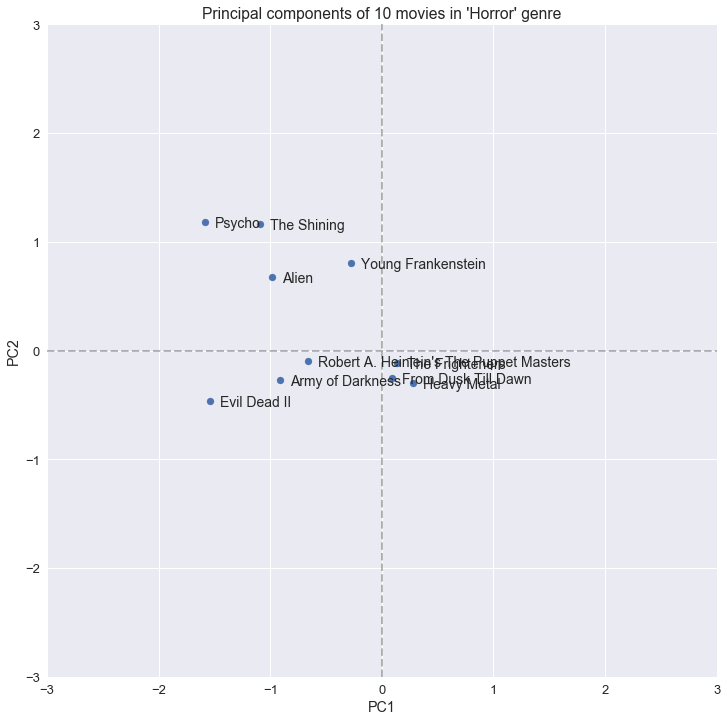

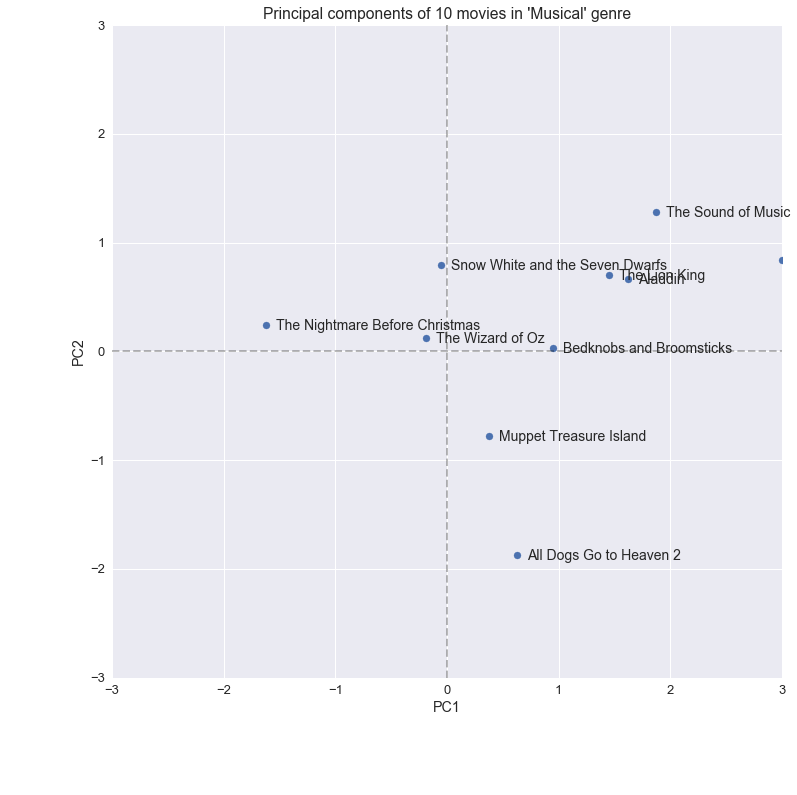

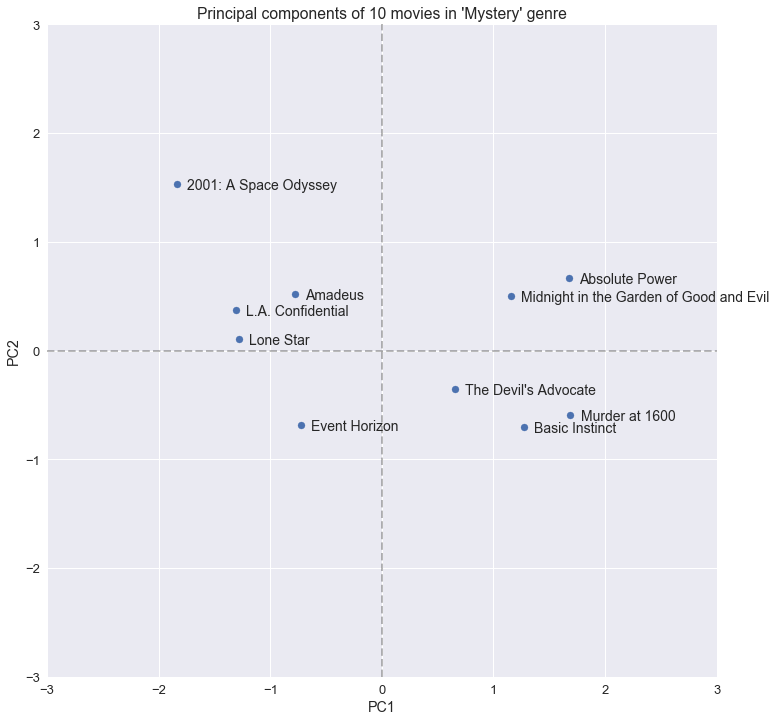

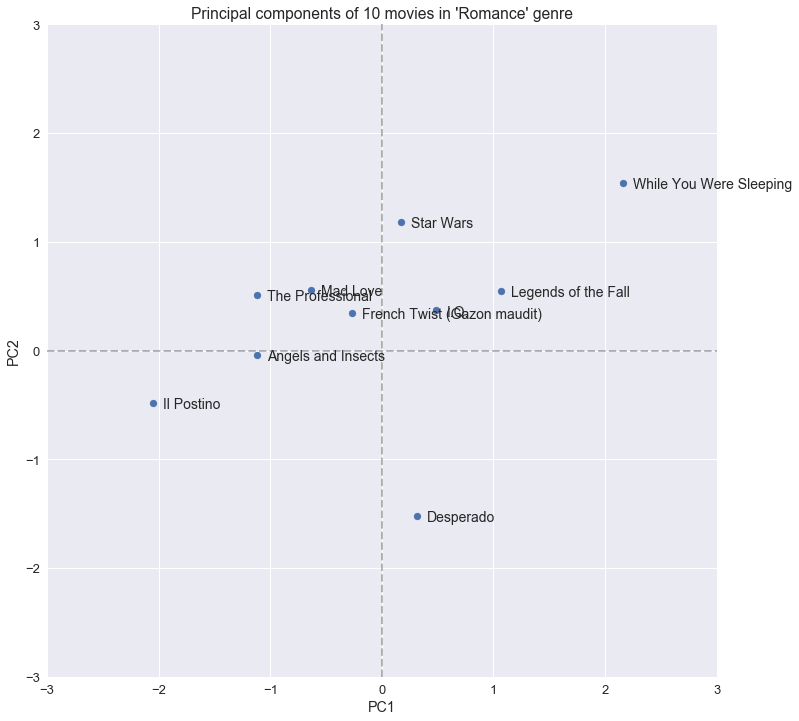

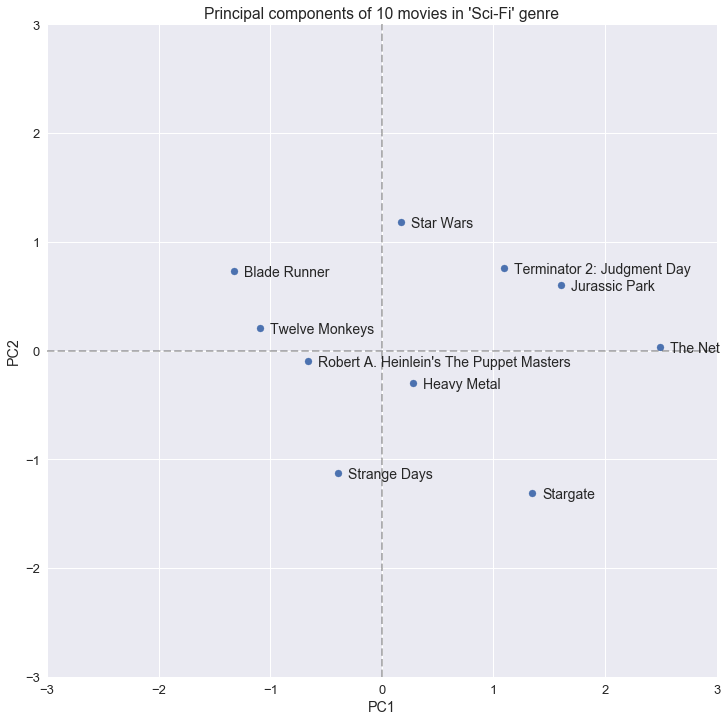

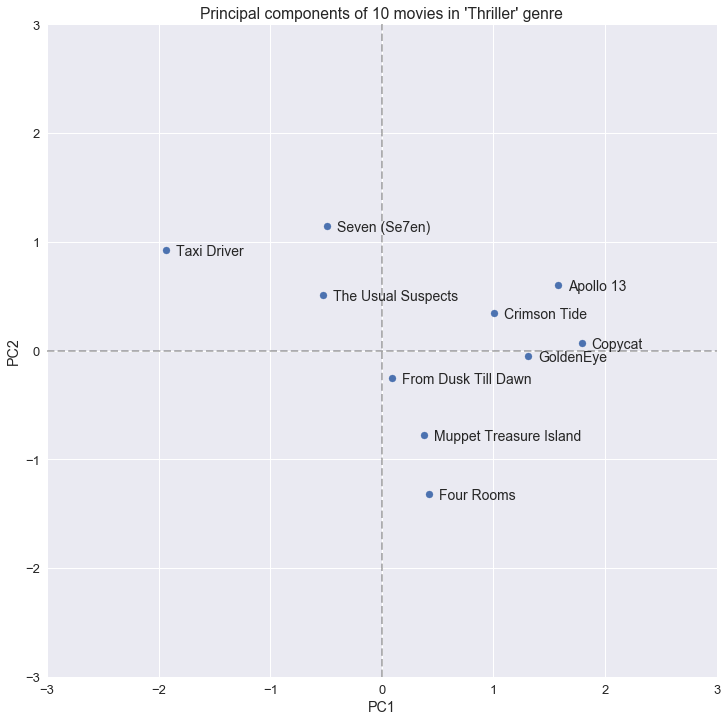

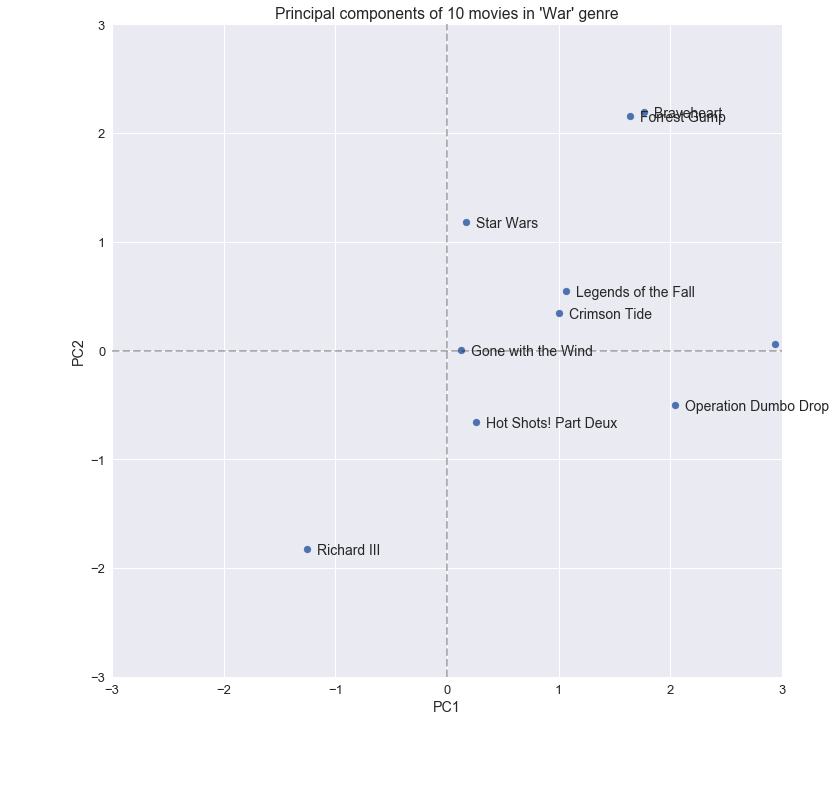

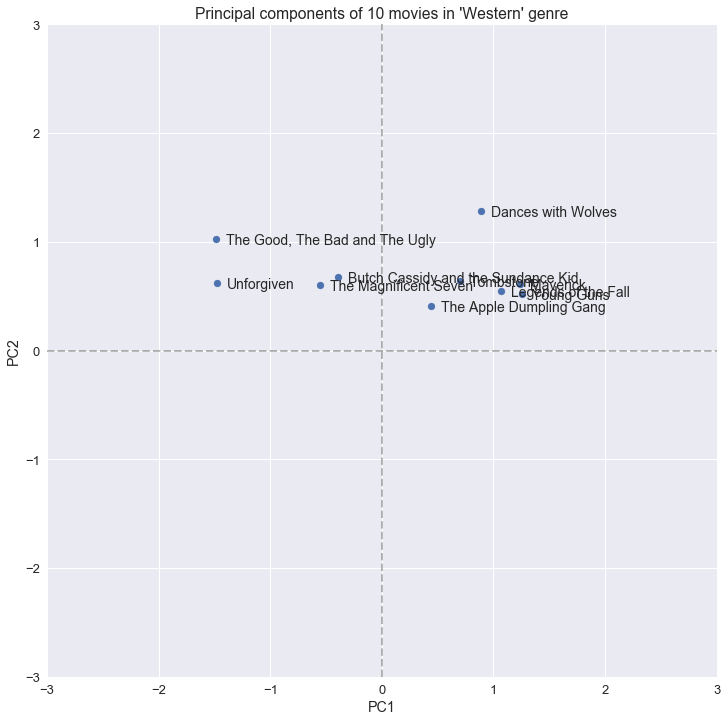

In [12]:
genres = ['Action','Adventure','Animation','Childrens','Comedy','Crime',
            'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
            'Thriller','War','Western']
#genres = ['Horror', 'Musical', 'Mystery']

for idx,val in enumerate(genres):
    g_inds_mov = np.array(np.where(movies[val]==1))[0]
    inds = g_inds_mov[:nmovies]

    fig,ax = plt.subplots(figsize=(12,12))
    ax.scatter(VT[0,inds],VT[1,inds])
    
    plt.title('Principal components of %i movies in \'%s\' genre' % (nmovies,val));
    plt.xlabel('PC1');
    plt.ylabel('PC2');
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.plot([xlim[0], xlim[1]], [0, 0], 'k--', lw=2, alpha=axis_opacity)
    plt.plot([0, 0], [ylim[0], ylim[1]], 'k--', lw=2, alpha=axis_opacity)

    ## Label movies
    for j in inds:
        ax.annotate(mtitles[j],(VT[0,j]+0.015*xrange,VT[1,j]-0.008*yrange),fontsize=14)


## Convex hull movies

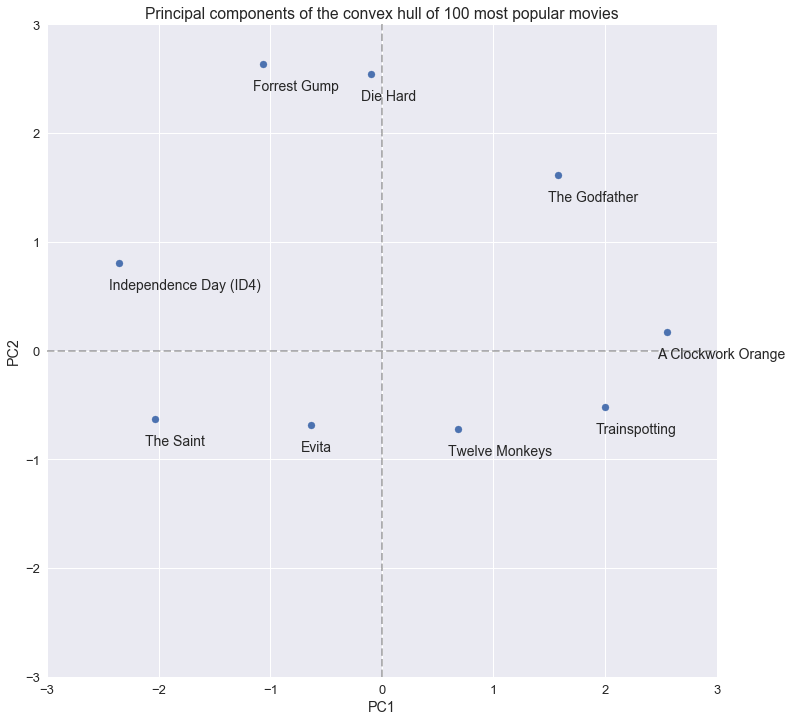

In [100]:
from scipy.spatial import ConvexHull

# Top popular movies to compute convex hull of
nmovies = 100

pop_inds_mov = np.argpartition(r_counts,-nmovies)[-nmovies:]
points = VT[:, pop_inds_mov].T
hull = ConvexHull(points)
inds = pop_inds_mov[hull.vertices]


fig,ax = plt.subplots(figsize=(12,12))
ax.scatter(VT[0,inds],VT[1,inds])
plt.title('Principal components of the convex hull of %d most popular movies' % nmovies);
plt.xlabel('PC1');
plt.ylabel('PC2');
plt.ylim(ylim)
plt.xlim(xlim)
plt.plot([xlim[0], xlim[1]], [0, 0], 'k--', lw=2, alpha=axis_opacity)
plt.plot([0, 0], [ylim[0], ylim[1]], 'k--', lw=2, alpha=axis_opacity)

## Label movies
for j in inds:
    ax.annotate(mtitles[j],(VT[0,j]-0.015*xrange,VT[1,j]-0.04*yrange),fontsize=14)